# PIC 16A Final Project

Group Members:
- JIANG, YANJUN (UID: 705834479)
- ZHANG, YITING (UID: 605325840)
- WANG, CHING-YI (UID: 605973970)



# Group Contributions Statement

All three of us wrote the data acquisition and preparation. YanJun led the Random Forest model, decision regions and data cleaning. Yiting led the Exploratory Analysis and KNN and SVM model. Ching-Yi led the logistic regression model and Feature Selection part. YanJun wrote the explanation of the Random Forest model, Yiting wrote the explanation of the Feature Selection and the model discussion, and Ching-Yi wrote the analysis for Exploratory Analysis. We all checked each other’s work and made revisions to the code and writing.


# Introduction

An important task in the ecology of the Antarctic is to catalog the many different species of penguins in that area. Determining the species of a penguin often requires a combination of biological expertise and many precise measurements, which can be difficult to obtain.

In the dystopian future, there are too many penguins. Because there are so many, we can’t take many detailed measurements on all of them! In order to classify the species of penguins in large volume, we need to figure out which measurements are most important for distinguishing penguin species.

#### Goal: Determine a small set of measurements that are highly predictive of a penguin’s species.

# Adlie Penguins
<figure class="image" style="width:50%">
    <img src="https://storage.googleapis.com/oceanwide_web/media-dynamic/cache/list_photo_gallery_470/v2-gallery_media/media60269f02176e2768416628.jpg" alt="">
  <figcaption><i></i></figcaption>
</figure>

# Chinstrap Penguins
<figure class="image" style="width:50%">
    <img src="https://images.radio.com/aiu-media/gettyimages-508886427-1--1ec424fe-eee5-4699-ad33-e7b5bbeb17e6.jpg" alt=""> 
  <figcaption><i></i></figcaption>
</figure>

# Gentoo Penguins
<figure class="image" style="width:50%">
    <img src="https://www.antarctica.gov.au/site/assets/files/45561/rs35100_dsc_0715.1200x0.jpg?nc=544d" alt=""> 
  <figcaption><i></i></figcaption>
</figure>

# Data Import and Cleaning

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

In [2]:
#import dataset Penguins

import urllib
def retrieve_data(url):
    """
    Retrieve a file from the specified url and save it in a local file 
    called data.csv. The intended values of url are:     
    """
    
    # grab the data and parse it
    filedata = urllib.request.urlopen(url) 
    to_write = filedata.read()
    
    # write to file
    with open("data.csv", "wb") as f:
        f.write(to_write)
        
retrieve_data("https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv")
penguins = pd.read_csv("data.csv")

In [3]:
# Drop NAs in the data set
penguins = penguins.dropna(subset=["Species",
                                   "Region",
                                   "Island",
                                   "Stage",
                                   "Individual ID",
                                   "Clutch Completion",
                                   "Date Egg",
                                   "Culmen Length (mm)", "Culmen Depth (mm)",
                                   "Flipper Length (mm)",
                                   "Body Mass (g)",
                                   "Sex",
                                   "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"])

penguins.shape
penguins.head()


,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN
5,PAL0708,6,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A2,Yes,11/16/07,39.3,20.6,190.0,3650.0,MALE,8.66496,-25.29805,NaN
6,PAL0708,7,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N4A1,No,11/15/07,38.9,17.8,181.0,3625.0,FEMALE,9.18718,-25.21799,Nest never observed with full clutch.


In [4]:
# Shorten the species name
penguins["Species"] = penguins["Species"].str.split().str.get(0)

In [5]:
#split the data into train and test set

from sklearn.model_selection import train_test_split

np.random.seed(1111)
raw_train, raw_test = train_test_split(penguins, test_size = 0.2)

We firstly frop the observations with NA entries in the columns: (`Species, Region, Island, Stage, Individual ID, Clutch Completion, Date Egg, Culmen Length (mm), Culmen Depth (mm), Flipper Length (mm), Body Mass (g), Sex, Delta 15 N (o/oo), Delta 13 C (o/oo)`). Then we shorten the species name in the `Species` column of the data set. For splitting the data into training data set and testing data set, we use the parameter `test_size = 0.2` to make the 20% of the data set as testing data and 80% as training data.

### Data Preprocessing

After we have the training data and testing data, we want both data sets to be splitting into X data set, which contains all selected features without response variable, and y data set that only contains the response variable, `Species`. We want to split into X and y since we will then use X_train and y_train to fit a model, then use the fitted model for the X_test to predict a new y data set and compare it with the y_test.

In [6]:
from sklearn import tree, preprocessing

def prep_penguins_data(data_df):
    """
    This function is used to preprocessing the input data set (training and testing),
    including:
        droping unnecessary columns; 
        droping the obersevations with unknwon sex;
        droping observations with NAs;
        encoding the qualitative features;
        and spliting the data set into X and y with repsonse Species.
    
    """
    df = data_df.copy()
    # Droping unnecessary columns
    df = df.drop(['studyName', 'Sample Number', 'Comments', 
                  'Individual ID', 'Stage','Region', 'Date Egg'], axis = 1)
    # Droping the obersevations with unknwon sex
    df = df[df["Sex"] != "."]
    # Droping observations with NAs
    df = df.dropna()
    # Encoding the qualitative features
    df[['Sex', 'Species','Island', 'Clutch Completion']] = df[
        ['Sex', 'Species','Island', 'Clutch Completion']].apply(
        preprocessing.LabelEncoder().fit_transform)
    
    # X data is the data without Species
    X = df.drop(['Species'], axis = 1)
    # y data only contains the Species column
    y = df['Species']
        
    return(df, X, y)

train, X_train, y_train = prep_penguins_data(raw_train)
test, X_test,  y_test  = prep_penguins_data(raw_test)

In [7]:
X_train.shape

(259, 9)

In [8]:
X_test.shape

(65, 9)

In [9]:
X_train.head()

,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
76,2,1,40.9,16.8,191.0,3700.0,0,8.47257,-26.02002
64,0,1,36.4,17.1,184.0,2850.0,0,8.62623,-26.11650
52,0,1,35.0,17.9,190.0,3450.0,0,8.19539,-26.17213
254,0,1,49.1,14.8,220.0,5150.0,0,7.89744,-26.63405
158,1,1,46.1,18.2,178.0,3250.0,0,8.85664,-24.55644


# Exploratory Analysis

In order to determine a small set of measurements that are highly predictive of a penguin’s species, we begin our exploratory analysis by looking at relationships between differnet variables.

After excluding non-essential variables, we arrived at 4 qualitative variables and 5 quantitative predictors. 

Let's begin our analysis by looking at the general data distribution for further predictor selection.

In [10]:
penguin = raw_train.copy()

penguin = penguin.drop(['studyName', 'Sample Number',
                        'Comments', 'Individual ID', 'Stage',
                           'Region', 'Date Egg'], axis = 1)
penguin = penguin[penguin["Sex"] != "."]
penguin = penguin.dropna()

penguin.shape

(259, 10)

### 1. Overall Observation

In [11]:
penguin.describe()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo)
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,44.286486,17.161390,201.567568,4237.741313,8.736363,-25.711070
std,5.445182,1.979071,14.244755,813.698022,0.543253,0.791807
min,33.100000,13.200000,172.000000,2850.000000,7.688700,-27.018540
25%,39.700000,15.600000,190.000000,3550.000000,8.301985,-26.360515
50%,45.200000,17.300000,198.000000,4100.000000,8.650150,-25.885470
75%,48.700000,18.600000,214.000000,4850.000000,9.181875,-25.062050
max,59.600000,21.500000,231.000000,6300.000000,10.025440,-23.903090


<AxesSubplot:ylabel='Species'>

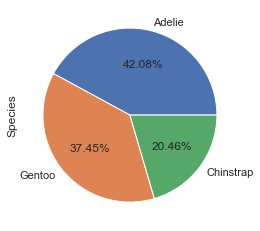

In [12]:
species=penguin["Species"].value_counts()
species.plot(kind='pie',autopct="%.2f%%")

- From the pie chart we can see that the total penguin sample consisted of 3 significant penguins, which are Adelie Penguin (42.90%), the Chinstrap penguin (20.68%), and the Gentoo penguin(36.42%).

### 2. Initial Analysis for Single Variable

We noticed that there are two pairs of predictors, `Culmen Depth (mm) and Culmen Length (mm)`, `Delta 15 N (o/oo) and Delta 13 C (o/oo)`, might be correlated based on common sense, so we want to look into the patterns of these specific variables to visualize their correlation in pairs and with our predictive variable "Species".

Text(0, 0.5, 'Frequency')

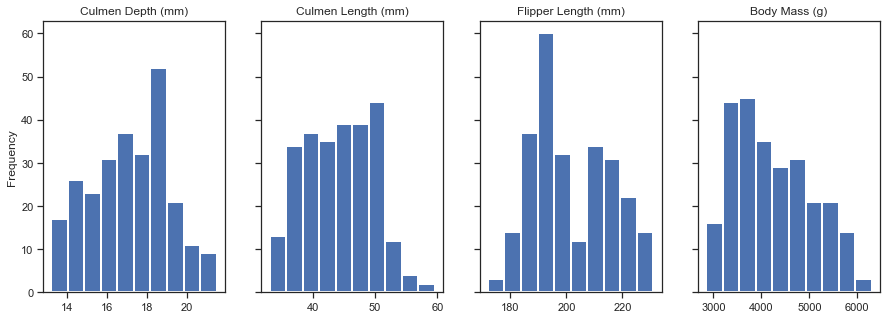

In [13]:
# let's take a look at some of the important numeric variables

col=["Culmen Depth (mm)",
    "Culmen Length (mm)",
    "Flipper Length (mm)",
    "Body Mass (g)"]

fig,ax = plt.subplots(1,4,figsize=(15,5),sharey=True)

for i in range(len(col)):
    ax[i].hist(penguin[col[i]],edgecolor='white', linewidth=2)
    ax[i].set(title=col[i])
    
ax[0].set_ylabel('Frequency')

- We found that `Culmen Length` and `Culmen Depth` have similar distribution, so **it might be more effective to select one of them** for our later feature selecton process and model implementation.

### 2-1. Boxplots for Culmen Length and Culmen Depth

<AxesSubplot:xlabel='Species', ylabel='Culmen Length (mm)'>

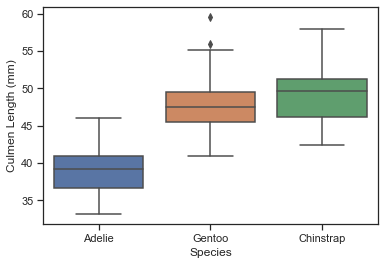

In [14]:
# Boxplot of Culmen length

sns.boxplot(x='Species', y='Culmen Length (mm)', data=penguin)

<AxesSubplot:xlabel='Species', ylabel='Culmen Depth (mm)'>

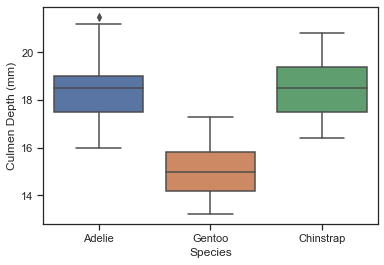

In [15]:
#boxplot Culmen depth

sns.boxplot(x='Species', y='Culmen Depth (mm)', data=penguin)

- While we analyze the `Culmen Length` from all three species through the boxplot, we discover that the Chinstrap penguin and Gentoo penguin have the significantly larger culmen length compared to the Adelie Penguin. However, when we take a look at the `Culmen Depth`, the Adelie Penguin and Chinstrap penguin seem to have a 2mm larger depth than the Gentoo penguin. In addition, among these three penguin species, the Chinstrap penguin tends to have a longer and deeper culmen compared to the other two. Our boxplots shows that the IQR range of the Culmen Depth and Culmen Length of all three of the penguins species are similar.

### 2-2. Histogram for Delta 15 N and Delta 13 C

Text(0.5, 1.0, 'Delta 15 N (o/oo)')

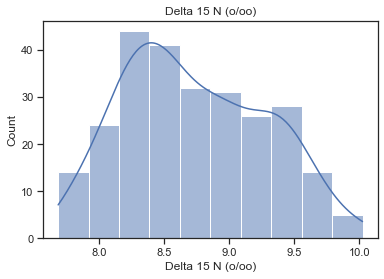

In [16]:
#distribution of Delta 15 N
sns.histplot(x = "Delta 15 N (o/oo)", data = penguin, kde = True)
plt.title("Delta 15 N (o/oo)")

Text(0.5, 1.0, 'Delta 13 C (o/oo)')

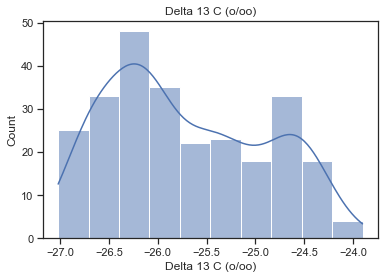

In [17]:
#distribution of Delta 13 C
sns.histplot(x = "Delta 13 C (o/oo)", data = penguin, kde = True)
plt.title("Delta 13 C (o/oo)")

- From the histogram of the Delta 15 N (o/oo) and Delta 13 C (o/oo), we observe that about 80% of penguins live in the environment where the Delta 15 N (o/oo) is between 8.0 to 9.5, and about 90% of penguins are distributed in the area where Delta 13 C (o/oo) is between -26.5 to -24.5. Thus, it is reasonable to infer that most penguins live in the same environment and in the same region. Moreover, we observe the general tendancy of both two predictors' histograms are about consistent.


### 2-3. Barplot for Body Mass over 3 Species

After exploring the potential similar pairs of predictors, we then want to check the pattern of another variable, `Body Mass (g)`, that we found with high association, over the 3 categorial species.

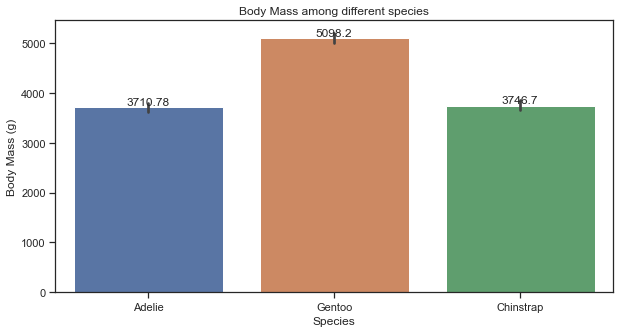

In [18]:
#body mass vs species

plt.figure(figsize=(10,5))
ax= sns.barplot(x=penguin['Species'],y=penguin['Body Mass (g)'])
plt.title('Body Mass among different species')
for i in ax.containers:
    ax.bar_label(i,)

plt.show()

- From the barplot of the body mass and speceis, we discover that the species has signficantly significant difference in body mass, the heaviest species among these three species is Gentoo Penguins which is 5091.1 grams, and the other two are about 3700 grams. Therefore, from our observation of the data, we found that the species is a high influence factor on the penguin’s phenotype. Even though they live in the same region (Anvers) and similar environment, they will still have different body mass, culmen length, and depth. 

### 2-4. Tables

In [19]:
# Species vs.Island

penguin.groupby(["Species","Island"])[["Island"]].aggregate([len])

#only Aelie Penguin lives on the Torgersen island.
#this could be a useful indicator to determine the species

Island
                       len
Species   Island          
Adelie    Biscoe        37
          Dream         40
          Torgersen     32
Chinstrap Dream         53
Gentoo    Biscoe        97

- **`Island` appears to be a good indicator for `Species`**. We can see that Adelie penguins exists on all three islands, while Chinstrap only dwell on Dream island and Gentoo only lives on Biscoe island.

In [20]:
# Species vs. Clutch Completion

penguin.groupby(["Species","Clutch Completion"])[["Clutch Completion"]].aggregate([len])

Clutch Completion
                                          len
Species   Clutch Completion                  
Adelie    No                               10
          Yes                              99
Chinstrap No                                9
          Yes                              44
Gentoo    No                                6
          Yes                              91

- We don't see any distinctive pattern among `Clutch Completion` in terms of different species

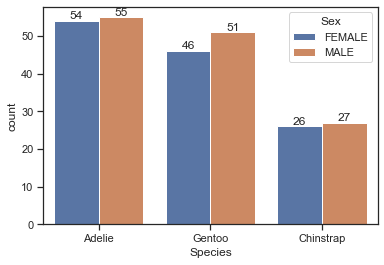

In [21]:
# Species vs. Sex

penguin.groupby(["Species","Sex"])[["Sex"]].aggregate([len])


fgrid=sns.countplot(data=penguin,x="Species", hue="Sex")


for container in fgrid.containers:
    fgrid.bar_label(container)

- For another qualitative variable `Sex`, we don't observe any patterns of sex among different species because `Sex` did not contribute large difference in the penguin’s `Species`.

### 3. Secondary Analysis for Combined Effects

After looking at the patterns and distribution for each single variable, we decided to see if there are any combined effect from different variables on `Species`.

Again, from just looking at the table, we can see that there is some distinction between the means of `Culmen Length and Culmen Depth` under different species. This verifies our assumption above.

In [22]:
# Spcecies vs Culmen Length and Culmen Depth

penguin.groupby(["Species"])[["Culmen Length (mm)","Culmen Depth (mm)"]].aggregate([np.mean,np.std])


Culmen Length (mm)           Culmen Depth (mm)          
                        mean       std              mean       std
Species                                                           
Adelie             39.009174  2.741942         18.399083  1.221527
Chinstrap          48.949057  3.463803         18.458491  1.155161
Gentoo             47.669072  3.089173         15.061856  1.001295

For creating feature subset with 1 quantitative predictor and 2 qualitative predictors, we want to add either `Sex` or `Island` on some pairs of predictors to check the further combined effects, specifically, if the combined features have significant pattern corresponding to the qualitative variable .

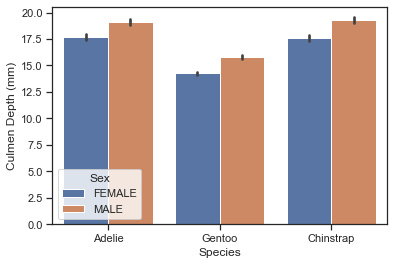

In [23]:
# Let's look further into Culmen Depth with respect to Sex.
fgrid=sns.barplot(data=penguin,x="Species",
                  y="Culmen Depth (mm)", 
                  hue="Sex")

""


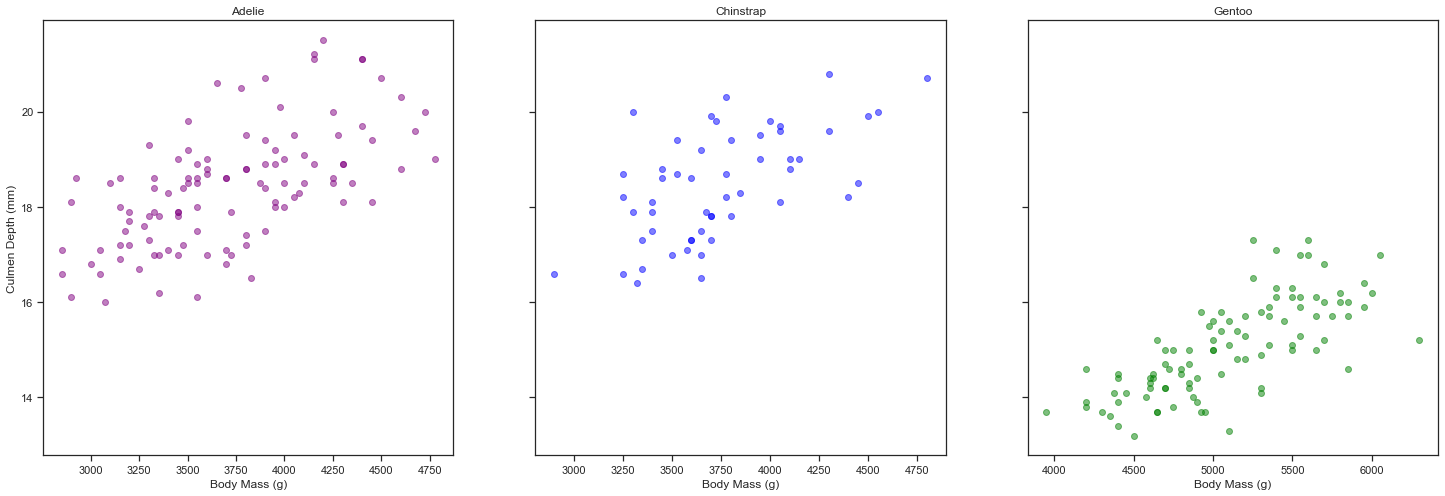

In [24]:
# Relationships between Culmen Dength and Body Mass

fig, ax = plt.subplots(1, 3,figsize=(25,8),sharey=True)


con={"Adelie": 0,
   "Chinstrap": 1,
   "Gentoo": 2,
  }

con_names={0 : "Adelie",
   1 : "Chinstrap",
   2 : "Gentoo",
  }

col={0 : "Purple",
   1 : "Blue",
   2 : "Green",
  }

def f(df):
    """
    A smart function that used for processing the data set grouping by Species 
    and apply for each observation of the input data set.
    """
    df = df.sort_values(["Body Mass (g)", "Culmen Depth (mm)"])
    x = con[df["Species"].iloc[0]]
    ax[x].scatter(df["Body Mass (g)"], df["Culmen Depth (mm)"], 
                  color = col[x], alpha = 0.5)
    ax[x].set(title = con_names.get(x),xlabel="Body Mass (g)")
    ax[0].set(ylabel = "Culmen Depth (mm)")
    
    
penguin.groupby(["Species"]).apply(f)


- Form the scatterplots above, we can observe that all species have some positive correlation between `Body mass` and `Culmen Depth` respectively. On the other hand, it also hows that `Culmen Depth` and `Body Mass` are different corresponding to each specie. 
- **Therefore, `Culmen Depth` and `Body Mass` could be considered in later analysis**.

Let's add in the `Island` and see if there's any noticeable patterns.

In [25]:
# Spcecies vs Flipper Length and Body Mass
# What if we add in Island?

penguin.groupby(["Species","Island"])[["Flipper Length (mm)","Body Mass (g)"]].aggregate([np.mean,np.std])

Flipper Length (mm)           Body Mass (g)            
                                   mean       std          mean         std
Species   Island                                                           
Adelie    Biscoe             188.675676  6.956428   3717.567568  522.841624
          Dream              190.575000  6.713505   3695.000000  443.044537
          Torgersen          192.343750  6.418770   3722.656250  442.151967
Chinstrap Dream              195.377358  7.646584   3746.698113  389.774273
Gentoo    Biscoe             217.443299  6.731408   5098.195876  505.030004

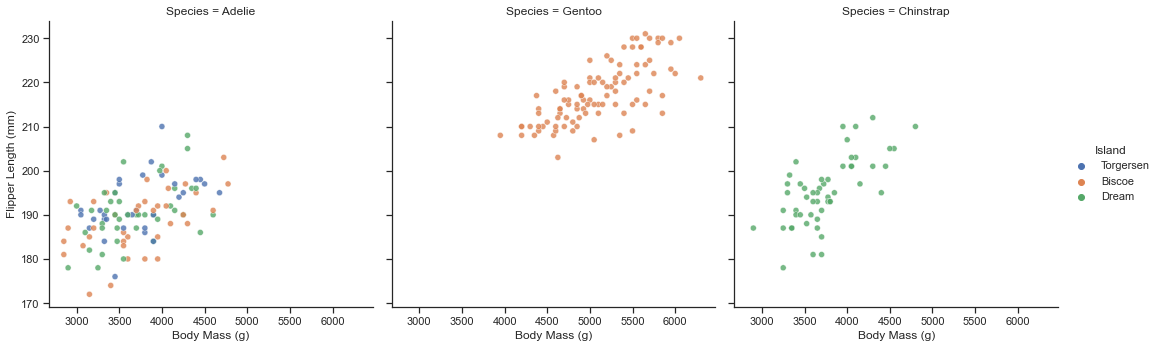

In [26]:
#let's visualize the above table
fgrid = sns.relplot(data = penguin, y = "Flipper Length (mm)", x="Body Mass (g)", 
                    hue = "Island", alpha = 0.8, col = "Species")

We can see the patterns and differences more distinctively if we combine the species into the same plot.

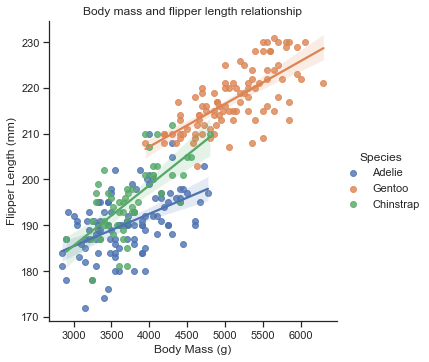

In [27]:
sns.lmplot(x= "Body Mass (g)",y= "Flipper Length (mm)",data=penguin,hue="Species")
plt.title('Body mass and flipper length relationship')
plt.show()

- Similarly, we can see that there is a positive correlation between flipper length and body mass. And it is also noticeable that the Gentoo penguins lived in the Biscoe island have significantly larger flipper length and body mass than the other 2 types of penguins, and whatever which island that Adelie penguins lived in, they generallt tend to have a smaller flliper length and body mass than the other two. 

In [28]:
# Spcecies vs Delta 13 C and Delta 15 N
# what if we add in Sex?

penguin.groupby(["Species", "Sex"])[["Delta 15 N (o/oo)","Delta 13 C (o/oo)"]].aggregate([np.mean,np.std])

Delta 15 N (o/oo)           Delta 13 C (o/oo)          
                              mean       std              mean       std
Species   Sex                                                           
Adelie    FEMALE          8.777434  0.489437        -25.807721  0.601231
          MALE            8.895111  0.358320        -25.816066  0.589998
Chinstrap FEMALE          9.303919  0.289799        -24.592199  0.190332
          MALE            9.462389  0.351246        -24.550556  0.192866
Gentoo    FEMALE          8.236287  0.248167        -26.258020  0.522236
          MALE            8.299017  0.248642        -26.186970  0.535155

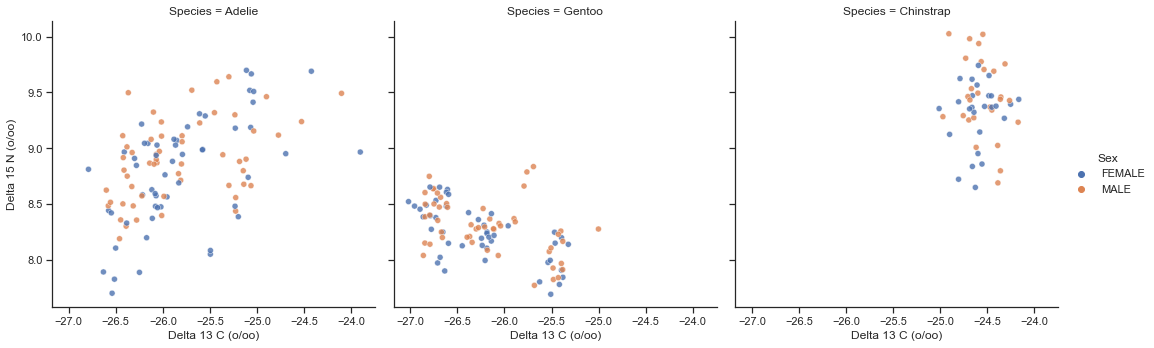

In [29]:
# let's visualize the above table
fgrid = sns.relplot(data = penguin, y = "Delta 15 N (o/oo)",x="Delta 13 C (o/oo)",
                    hue = "Sex", alpha = 0.8, col = "Species")

In [30]:
# Spcecies vs Delta 13 C and Delta 15 N
# what if we add in Sex?

penguin.groupby(["Species", "Island"])[["Delta 15 N (o/oo)","Delta 13 C (o/oo)"]].aggregate([np.mean,np.std])

Delta 15 N (o/oo)           Delta 13 C (o/oo)          
                                 mean       std              mean       std
Species   Island                                                           
Adelie    Biscoe             8.758572  0.336493        -25.987283  0.489316
          Dream              8.942841  0.419655        -25.700363  0.599959
          Torgersen          8.794742  0.518352        -25.748642  0.660797
Chinstrap Dream              9.384649  0.329333        -24.570985  0.190937
Gentoo    Biscoe             8.269269  0.249118        -26.220664  0.527519

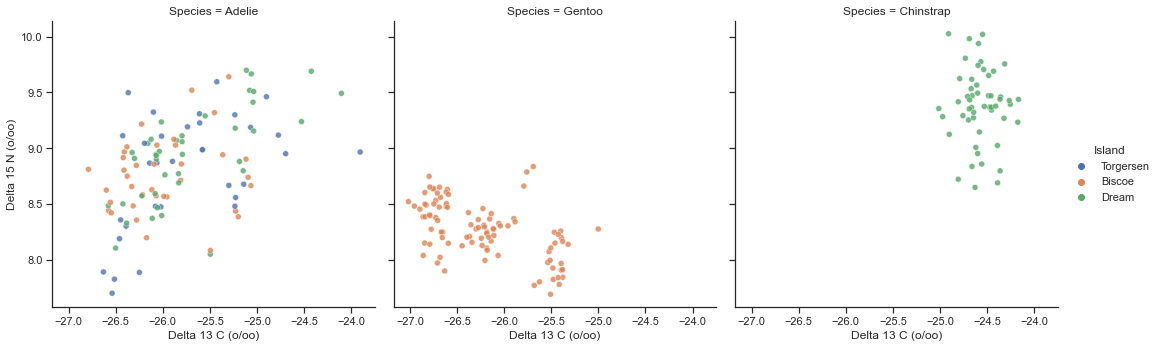

In [31]:
# let's visualize the above table
fgrid = sns.relplot(data = penguin, y = "Delta 15 N (o/oo)",x="Delta 13 C (o/oo)", 
                    hue = "Island",  alpha = 0.8, col = "Species")

- From the above graph, we can also observe that correlation between `Delta 15 N` and `Delta 13 C` varies among `Species`.
- This proves our hypothesis above, `Sex` is not a great indicator for penguins' species. **Therefore, we would consider `Island` as a better qualitative predictor than `Sex` with a more significant pattern with `Species`.**

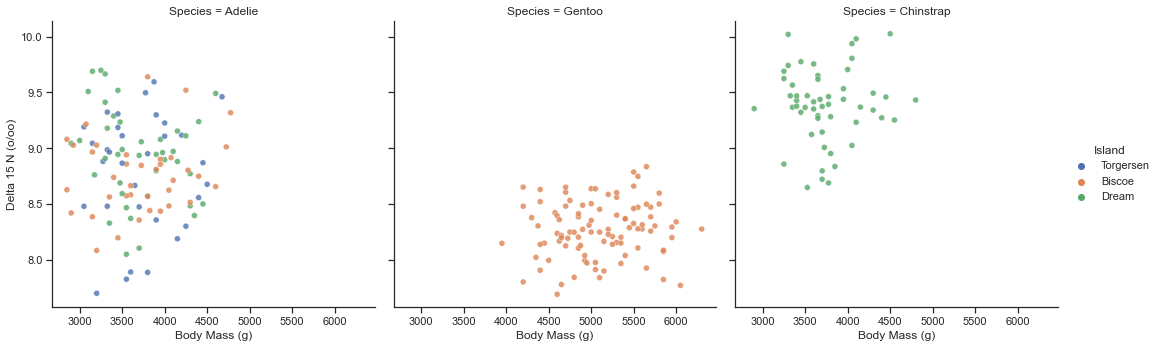

In [32]:
# spcecies vs delta 15 N and body mass vs island
fgrid = sns.relplot(data = penguin, y = "Delta 15 N (o/oo)", 
                    x="Body Mass (g)", hue = "Island", 
                    alpha = 0.8, col = "Species")

- The correlation between `Delta 15 N` and `Body Mass` is distinctive among species where Gentoo has higher body mass with lower Delta 15 N, Cinstrap has lower body mass with higher Delta 15 N, and Adelie has lower body mass but evenly distributed Delta 15 N.

### 4. Conclusion

From our analysis above, we decided to pick the following variables for our feature selection:
- Culmen Depth (mm)
- Flipper Length (mm)
- Body Mass (g)
- Delta 15 N (o/oo)
- Delta 13 C (o/oo)
- Island


In the next section, we will use feature selection to decide the best three variables to predict the response.


# Feature Selection

Feature selection is the process to reduce the number of input variables when developing a predictive model. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model. 

In particular, we are trying to find two quantitative and one qualitative variables that would best describe our predictive variable-- `Species`.

We decided to use heat map for checking correlation, check CV score with logistic regression, choose the highest k scores, and use decision tree to see the feature importance for selecting the candidate feature subsets with highest cross-validation score.

### 1. Heat Map - Correlation

<AxesSubplot:>

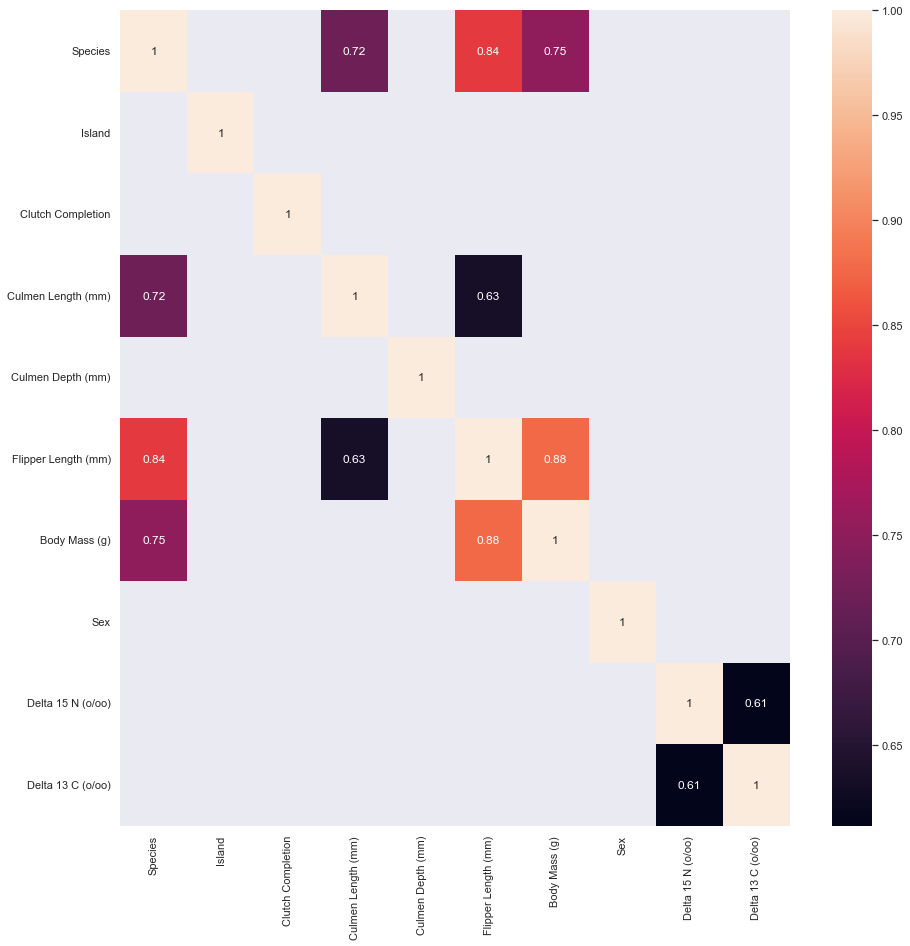

In [33]:
# Dispplay only correlation that is bigger than 0.6
sns.set(rc={'figure.figsize': (15, 15)})
sns.heatmap(train.corr()[(train.corr()>0.6)],annot=True)

From the `prep_penguins_data()` function, notice that the function also return a preprocessed training and testing data set containing both X and y. We created a heated map for the proprocessed training data with X and y to check the correlation between each potential pairs of the variables. With specifying `train.corr()>0.6`, we can check which variable has strong correlation larger than 0.6 with `Species`, so we can use these variable for reference of prediction in our future study. At the same time, with this specified condition, we are also able to see which pair of predictors have strong correlation because when predictors in the same models are strongly correlated, they cannot independently predict the response variable. Overall, from the above heated map, **`Culmen Length (mm), Flipper Length (mm), Body Mass (g)` has strong correlation with `Species`**, and the strong associated between `Culmen Length (mm) and Flipper Length (mm)`, `Flipper Length (mm) and Body Mass (g)`, `Delta 15 N (o/oo) and Delta 13 C (o/oo)` should be considered.

### 2. Logistic Regression - Checking CV Scores

When we firstly ran the logistic regression model for our training data set, we get an overfitting CV score = 1.0. To avoid the overfitting and get more referential CV scores for our feature selection, we decided to normalized our training data set and apply the normalized data to the logistic regression model.

In [34]:
from sklearn.preprocessing import StandardScaler

def normalization(data):
    """
    This function normalize th numerical variables in the
    dataset and combines with the categorical variables.
    Use penguins as the original dataset.
    """
    #normalize data
    scaler = StandardScaler()
    #copy the dataset
    d=data.copy()
    # create an unique ID to combine the data
    list = [i for i in range(1,len(d)+1)]
    d['ID'] = list
    #extract numerical columns from X_train
    num = ["Culmen Length (mm)", "Culmen Depth (mm)", 
       "Flipper Length (mm)", "Body Mass (g)", 
       "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]
    # fit and transform the data
    scaled_X = scaler.fit_transform(d[num])
    #convert the scaled array into dataframe
    scaled_X= pd.DataFrame(scaled_X, columns=num)
    #assign unique ID
    scaled_X['ID']=list
    #combine with the categorical variables from X_train
    cat=["ID","Island","Clutch Completion","Sex"]
    categorical= d[cat]
    
    return pd.merge(categorical,scaled_X, on='ID')
 
X_scaled=normalization(X_train)
X_test_scaled=normalization(X_test)

In [35]:
#conduct cross validation on the logistic model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def check_column_score(cols):
    """
    Trains and evaluates a model via cross 
    validation on the columns of the data 
    with selected indeces
    """
    LR=LogisticRegression(max_iter = 1000)
    print("training with columns" + str(cols))
    return cross_val_score(LR,X_scaled[cols],y_train,cv=10).mean()
    

According to the suggested predictors from the Exploratory Data Analysis (EDA) section, we should create a big list containing all possible combinations created by all suggested quantitative variables. For the qualitative variable, our EDA section only suggest `Island` as a good indicator.

In [36]:
combos = []
feature = ['Body Mass (g)', "Flipper Length (mm)", "Delta 15 N (o/oo)", 
          "Delta 13 C (o/oo)", "Culmen Depth (mm)"]
for i in range(len(feature)):
     for j in range(i+1,len(feature)):
            combos.append([feature[i],feature[j],"Island"])
combos

[['Body Mass (g)', 'Flipper Length (mm)', 'Island'],
 ['Body Mass (g)', 'Delta 15 N (o/oo)', 'Island'],
 ['Body Mass (g)', 'Delta 13 C (o/oo)', 'Island'],
 ['Body Mass (g)', 'Culmen Depth (mm)', 'Island'],
 ['Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Island'],
 ['Flipper Length (mm)', 'Delta 13 C (o/oo)', 'Island'],
 ['Flipper Length (mm)', 'Culmen Depth (mm)', 'Island'],
 ['Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Island'],
 ['Delta 15 N (o/oo)', 'Culmen Depth (mm)', 'Island'],
 ['Delta 13 C (o/oo)', 'Culmen Depth (mm)', 'Island']]

In [37]:
for featureSelect in combos:
    x=check_column_score(featureSelect)
    print("CV score is "+ str(np.round(x,3)))

training with columns['Body Mass (g)', 'Flipper Length (mm)', 'Island']
CV score is 0.803
training with columns['Body Mass (g)', 'Delta 15 N (o/oo)', 'Island']
CV score is 0.857
training with columns['Body Mass (g)', 'Delta 13 C (o/oo)', 'Island']
CV score is 0.919
training with columns['Body Mass (g)', 'Culmen Depth (mm)', 'Island']
CV score is 0.795
training with columns['Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Island']
CV score is 0.861
training with columns['Flipper Length (mm)', 'Delta 13 C (o/oo)', 'Island']
CV score is 0.957
training with columns['Flipper Length (mm)', 'Culmen Depth (mm)', 'Island']
CV score is 0.811
training with columns['Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Island']
CV score is 0.892
training with columns['Delta 15 N (o/oo)', 'Culmen Depth (mm)', 'Island']
CV score is 0.869
training with columns['Delta 13 C (o/oo)', 'Culmen Depth (mm)', 'Island']
CV score is 0.915


**From our logistic model with cross validation, the best subsets of variables are:**

- ['Flipper Length (mm)', 'Delta 13 C (o/oo)', 'Island'] with CV score is 0.957
- ['Body Mass (g)', 'Delta 13 C (o/oo)', 'Island'] with CV score is 0.919
- ['Delta 13 C (o/oo)', 'Culmen Depth (mm)', 'Island'] with CV score is 0.915

### 3. SelectKBest - Select Features with the K Highest Scores

               Feature       Score
4  Flipper Length (mm)  412.431021
2   Culmen Length (mm)  288.312034
3    Culmen Depth (mm)  267.810114
5        Body Mass (g)  262.743324
8    Delta 13 C (o/oo)  183.031481
7    Delta 15 N (o/oo)  180.380580
0               Island  106.202478
1    Clutch Completion    2.329638
6                  Sex    0.047786


<AxesSubplot:xlabel='Score', ylabel='Feature'>

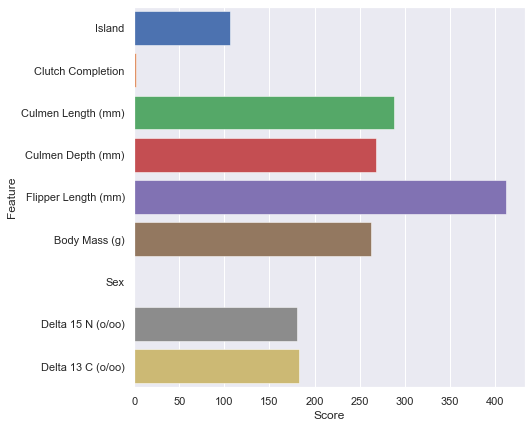

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(12,'Score'))  #print 10 best features

#Plotting Feature Importance
fig, ax = plt.subplots(figsize=(7,7))
plot=sns.barplot(data=featureScores, x='Score', y='Feature',
                 linewidth=0.5, saturation=2, orient='h')
plot

### 4. Decision Tree - Feature Importance

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn import tree

T=tree.DecisionTreeClassifier(max_depth=3)
cv_scores=cross_val_score(T,X_train,y_train,cv=5)
cv_scores

array([0.98076923, 0.94230769, 0.96153846, 0.92307692, 0.98039216])

In [40]:
best_score=-np.inf
N=30 #largest max depth
scores=np.zeros(N)

for d in range(1,N+1):
    T=tree.DecisionTreeClassifier(max_depth=d)
    scores[d-1]=cross_val_score(T,X_train,y_train,cv=5).mean()
    if scores[d-1]>best_score:
        best_depth=d
        best_score=scores[d-1]
        
best_depth,best_score

(22, 0.9768476621417799)

[Text(0.5, 1.0, 'Best Depth: 22')]

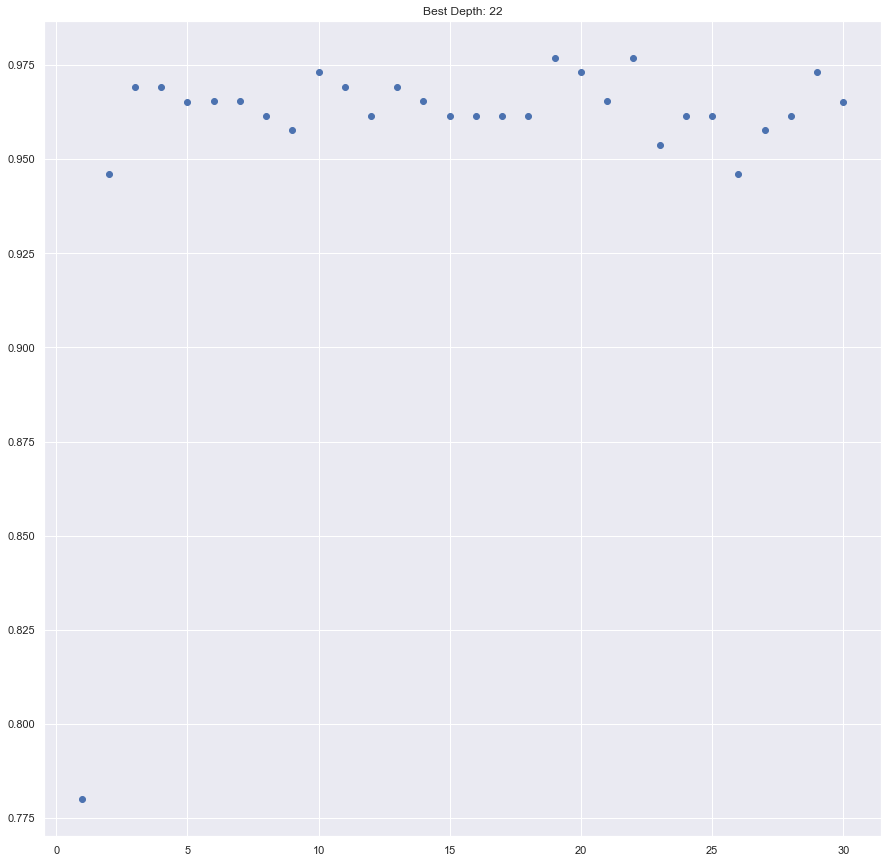

In [41]:
fig,ax=plt.subplots(1)
ax.scatter(np.arange(1,N+1),scores)
ax.set(title="Best Depth: "+str(best_depth))

In [42]:
#evaluate against test dataset
T=tree.DecisionTreeClassifier(max_depth=best_depth)
T.fit(X_train,y_train)
T.score(X_test,y_test)

0.9692307692307692

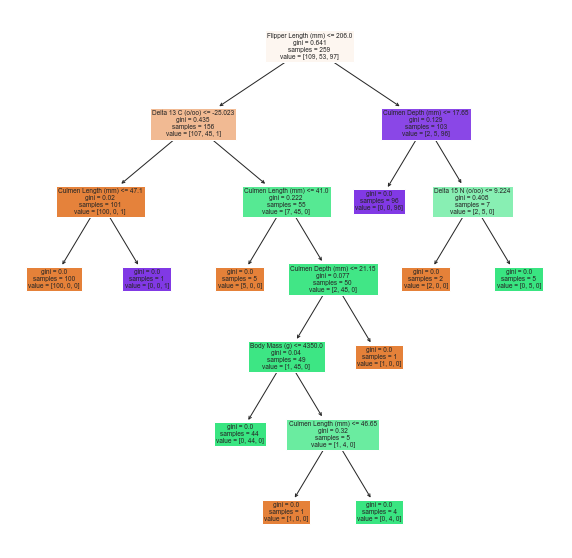

In [43]:
#visualize the plot
fig,ax=plt.subplots(1,figsize=(10,10))

p=tree.plot_tree(T,
                 filled=True,
                 feature_names=X_train.columns
                )

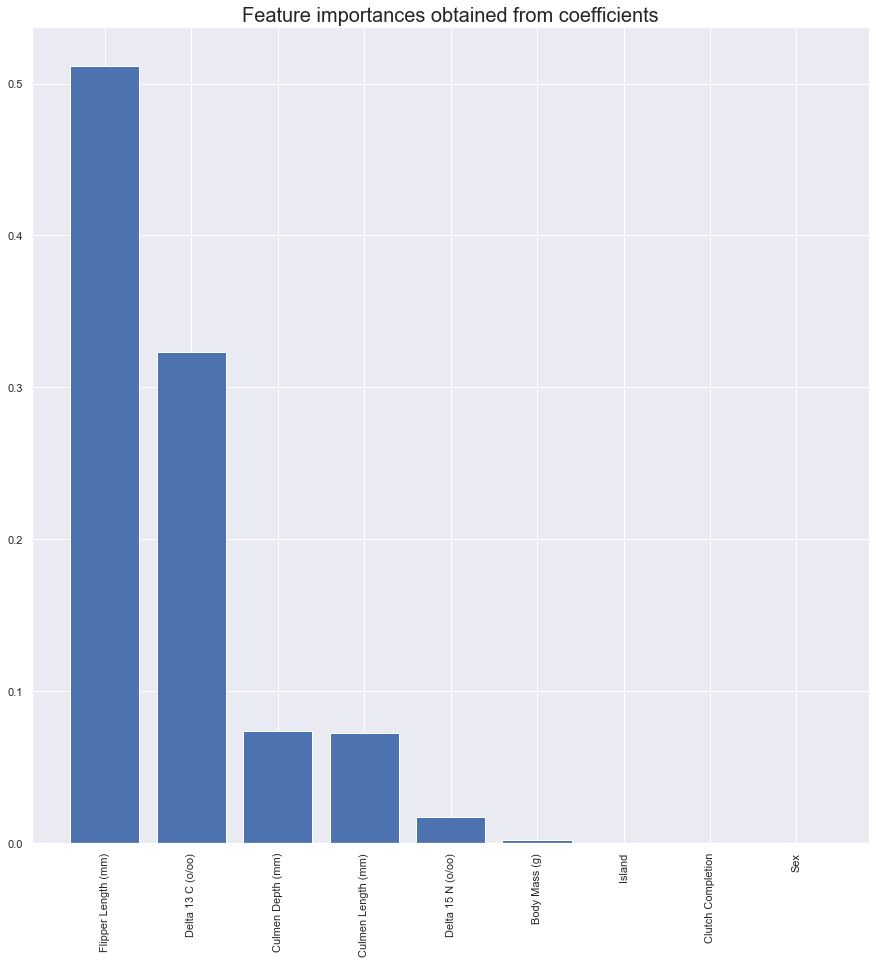

In [44]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': T.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)


plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

**From decision tree, best set of variables are:**
- Flipper Length (mm)
- Delta 13 C (o/oo) 
- Culmen Depth (mm) 

Combined with the suggested predictors, we would consider `Culmen Depth (mm)` as a better indicator than `Culmen Length (mm)` even though they do not have great difference of importance with the decision tree.

### 5. Conclusion

According to our feature selection models, we decide to use the follow sets of variables for our model implementation:

- ['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island'] 
- ['Delta 13 C (o/oo)', 'Body Mass (g)', 'Island'] 
- ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island'] 

# Modeling


### Feature Sets

In [45]:
#['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island'] 
mask=['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island']
X_train_1= X_train[mask]
X_test_1= X_test[mask]
X_train_1.head()

,Delta 13 C (o/oo),Flipper Length (mm),Island
76,-26.02002,191.0,2
64,-26.11650,184.0,0
52,-26.17213,190.0,0
254,-26.63405,220.0,0
158,-24.55644,178.0,1


In [46]:
#['Delta 13 C (o/oo)', 'Body Mass (g)', 'Island']
mask=['Delta 13 C (o/oo)', 'Body Mass (g)', 'Island']
X_train_2= X_train[mask]
X_test_2 = X_test[mask]
X_train_2.head()

,Delta 13 C (o/oo),Body Mass (g),Island
76,-26.02002,3700.0,2
64,-26.11650,2850.0,0
52,-26.17213,3450.0,0
254,-26.63405,5150.0,0
158,-24.55644,3250.0,1


In [47]:
#['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island']
mask=['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island']
X_train_3= X_train[mask]
X_test_3 = X_test[mask]
X_train_3.head()

,Culmen Depth (mm),Delta 13 C (o/oo),Island
76,16.8,-26.02002,2
64,17.1,-26.11650,0
52,17.9,-26.17213,0
254,14.8,-26.63405,0
158,18.2,-24.55644,1


In [48]:
print("First feature subset's shape:",X_train_1.shape, X_test_1.shape)
print("Second feature subset's shape:",X_train_2.shape, X_test_2.shape)
print("Third feature subset's shape:",X_train_3.shape, X_test_3.shape)
print("Training y and Test y's shapes:",y_train.shape, y_test.shape)

First feature subset's shape: (259, 3) (65, 3)
Second feature subset's shape: (259, 3) (65, 3)
Third feature subset's shape: (259, 3) (65, 3)
Training y and Test y's shapes: (259,) (65,)


In [49]:
def plot_regions(c,X,y,island):
    """
    With specified island, this function is used forplotting the predicted 
    decision regions for species in each island with the model c and visualizing 
    the difference between the predicted regions with the true data as scatter 
    points.
    
    Parameters
    ----------
    c: the model that would be used for the decision boundaries.
    X: the training data set with the two quantitative features in
        the selected best feature set with specified island.
    y: the training data set with species as the only feature and the
        specified island.
    island: integer, user will be required to specified which island 
    (encoded label) 
        they want to visualize the decision regions of the species..
    
    Output
    ----------
    Output a decision boundaries plot for the penguin
    species in the specified island.
    
    """
    # Extract the observations that lived in the specified island from X 
    # and y data set.
    X=X[X_train["Island"] == island]
    y=y[X_train["Island"] == island]
    
    # Create a dictionary with the encoded labels corresponding to their 
    # original island for showing which island is created by this function
    lands={0 : "Biscoe",
               1 : "Dream",
               2 : "Torgersen"}
    
    # Extract x0 as the first feature of X for x-axis,
    # amd x1 as the second feature of X for y-axis
    x0=X[best_set[0]]
    x1=X[best_set[1]]
    
    # Made a random elaborate grid
    grid_x=np.linspace(x0.min(),x0.max(), 501)
    grid_y=np.linspace(x1.min(),x1.max(), 501)

    # Made a mesh grid and unravel it
    xx,yy=np.meshgrid(grid_x,grid_y) 
    
    # Ravel the mesh grid of xx and yy
    XX=xx.ravel()
    YY=yy.ravel()
    # Since the model c is expecting 3 features, the 2 quantitative 
    # features and the 1 qualitative feature (island),
    # we need to create 1 more array for the island.
    # And considering this function creates plot for only one island
    # at one time, so just create an ones array with same shape of XX
    # and multiply with the encoded island label
    ZZ = np.ones(XX.shape)*island
    
    # predict with the given XX, YY, ZZ
    p=c.predict(np.c_[XX,YY,ZZ])
    p=p.reshape(xx.shape)
    
    ax[island].scatter(x0,x1,c=y,cmap="jet", vmin = 0, vmax = 2)
    ax[island].contourf(xx,yy,p,cmap="jet",alpha=0.2, vmin = 0, vmax = 2)
    ax[0].set(ylabel = str(best_set[1]))
    ax[island].set(xlabel = str(best_set[0]),
                       title = "Decision Regions for island " + lands[island])

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Confusion matrix
def confusion_matrix(y_true, y_pred):
    """
    This function will create a confusion matrix as a data frame to compare
    the true y data (y_test) and the predicted y data (y_pred) produced by a
    model.
    
    Parameters
    ----------
    y_true: the y_test data as true response data set.
    y_pred: the y_pred data produced by a model as predicted data set.
    
    Output
    ----------
    table: a data frame with row variables are the predicted penguin species
        from y_pred and the column variables are the true penguin species from
        y_test.
    
    """
    # Find the unique encoded labels from the y_true
    labels = unique_labels(y_true)
    
    SpecieLabels={0 : "Adelie",
                  1 : "Chinstrap",
                  2 : "Gentoo"}
    
    # Format the Row names and Column names
    pred_labels = [f'Predicted {SpecieLabels[label]}' for label in labels] 
    true_labels = [f'Actual {SpecieLabels[label]}' for label in labels] 
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns = pred_labels, 
                         index = true_labels)
    return table


### (I) Random Forest

Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model's prediction.

In [51]:
#cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
best_score = 0

In [52]:
trainOptions = [X_train_1, X_train_2, X_train_3]
for train_option in trainOptions:
    for d in range(1, 30):
        RF = RandomForestClassifier(max_depth = d)
        cv_score = cross_val_score(RF, train_option, 
                                   y_train, cv=10).mean()

        if cv_score > best_score:
            best_depth = d
            best_score = cv_score
    print("Best Depth ", best_depth, 
          " for ", [i for i in train_option.columns],
         "with best cv score as ", best_score, "\n")
    best_score = 0

Best Depth  29  for  ['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island'] with best cv score as  0.9807692307692308 

Best Depth  3  for  ['Delta 13 C (o/oo)', 'Body Mass (g)', 'Island'] with best cv score as  0.9576923076923076 

Best Depth  4  for  ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island'] with best cv score as  0.9383076923076924 



In [53]:
RF = RandomForestClassifier(n_estimators=300, 
                             max_depth=29)

# Fit RandomForestClassifier
RF.fit(X_train_1, y_train)
# Predict the test set labels
y_pred = RF.predict(X_test_1)
y_pred

array([2, 1, 1, 2, 0, 0, 2, 1, 2, 0, 0, 2, 1, 2, 0, 2, 2, 0, 0, 2, 1, 2,
       0, 1, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 1, 1,
       0, 2, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 1, 0, 2, 2, 0, 0, 1, 1, 0])

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       0.87      0.93      0.90        14
           2       1.00      1.00      1.00        21

    accuracy                           0.95        65
   macro avg       0.94      0.95      0.95        65
weighted avg       0.96      0.95      0.95        65



array([[28,  2,  0],
       [ 1, 13,  0],
       [ 0,  0, 21]], dtype=int64)

In [55]:
from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(y_test, y_pred))
print("Test score: ",RF.score(X_test_1, y_test))
print("Training score: ", RF.score(X_train_1, y_train))

Accuracy :  0.9538461538461539
Test score:  0.9538461538461539
Training score:  1.0


C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


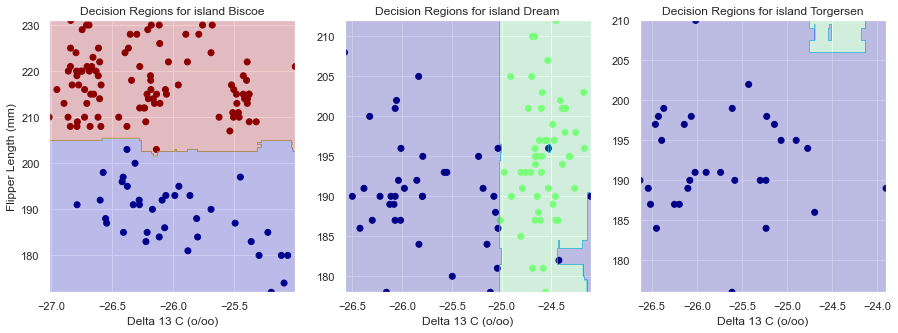

In [56]:
best_set = ['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island']
X=X_train_1[best_set[:2]]
y=y_train
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5)) 
plot_regions(RF,X, y,0)
plot_regions(RF,X, y,1)
plot_regions(RF,X, y,2)

Compare to the scatterplots generated by the penguin data set with same feature set in real situation:

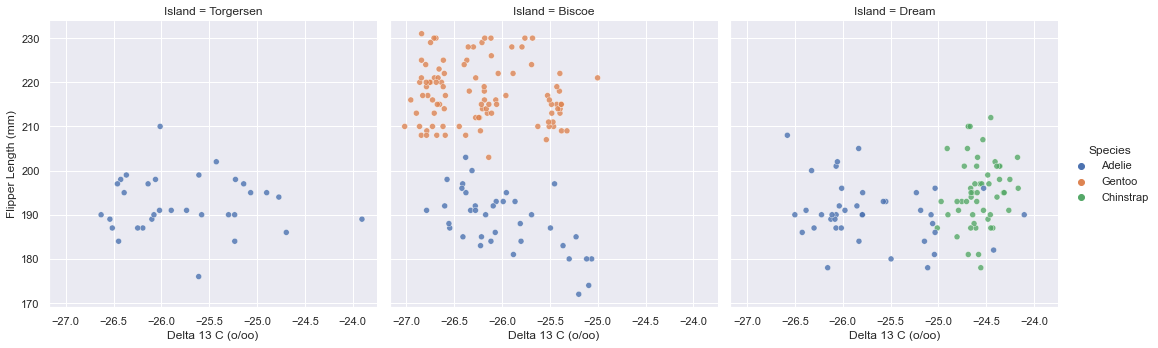

In [57]:
# Spcecies vs Delta 13 C and FLippper Length vs Island
fgrid = sns.relplot(data = penguin, x = "Delta 13 C (o/oo)", 
                    y='Flipper Length (mm)', 
                    hue = "Species", 
                    alpha = 0.8, col = "Island")

- Blue: Adelie Penguin 

- Green: Chinstrap Penguin

- Red: Gentoo Penguin

**Performance:**
Achieved an accuracy score of **0.9846** from Random Forest model with features ['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island'].

**Discussion:**
Previously in our exploratory analysis, we see that for Island Dream and Biscoe, there are two types of Penguins; for island Torgersen, only Adelie penguins exist. Our decision region graph capture this phenomenon. The mistakes made by the Random Forest model including incorrectly identify some of the Adelie penguins as Chinstrap on the Dream island and Gentoo penguins as Adelie penguins on the Biscoe island.

If we look at the scatter plot below, we can see why the model made the mistakes. 
On the Dream island, there are a few outliers of Adelie penguins where the Delta 13 C value are among the Chinstrap scatter points. 
On the Biscoe island, there is one data point of Gentoo Penguin that are closer to the data points of Adelie penguins. The model incorrectly cetegorize that data point. 

### (II) K Nearest Neighbors

In KNN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

In [58]:
from sklearn.neighbors import KNeighborsClassifier

# Cross Validation
best_score = 0
for train_option in trainOptions:
    for d in range(1,30):
        KNN = KNeighborsClassifier(n_neighbors = d)
        cv_score = cross_val_score(KNN, 
                                   train_option, 
                                   y_train, 
                                   cv=10).mean()
        #ax.scatter(d, cv_score, color = "black")
        if cv_score > best_score:
            best_n_neighbors = d
            best_score = cv_score
    print("Best N_Neighbors ", best_n_neighbors, 
          " for ", [i for i in train_option.columns],
         "with best cv score as ", best_score, "\n")
    best_score = 0

Best N_Neighbors  1  for  ['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island'] with best cv score as  0.8998461538461537 

Best N_Neighbors  1  for  ['Delta 13 C (o/oo)', 'Body Mass (g)', 'Island'] with best cv score as  0.8187692307692307 

Best N_Neighbors  6  for  ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island'] with best cv score as  0.9112307692307693 



In [59]:
KNN = KNeighborsClassifier(n_neighbors=6)
KNN.fit(X_train_3, y_train)
y_pred = KNN.predict(X_test_3)

In [60]:
print(classification_report(y_test,y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       0.87      0.93      0.90        14
           2       0.95      1.00      0.98        21

    accuracy                           0.94        65
   macro avg       0.93      0.94      0.93        65
weighted avg       0.94      0.94      0.94        65



array([[27,  2,  1],
       [ 1, 13,  0],
       [ 0,  0, 21]], dtype=int64)

In [61]:
print ("Accuracy : ", accuracy_score(y_test, y_pred))
print("Test score: ",KNN.score(X_test_3, y_test))
print("Training score: ", KNN.score(X_train_3, y_train))

Accuracy :  0.9384615384615385
Test score:  0.9384615384615385
Training score:  0.9266409266409267


C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


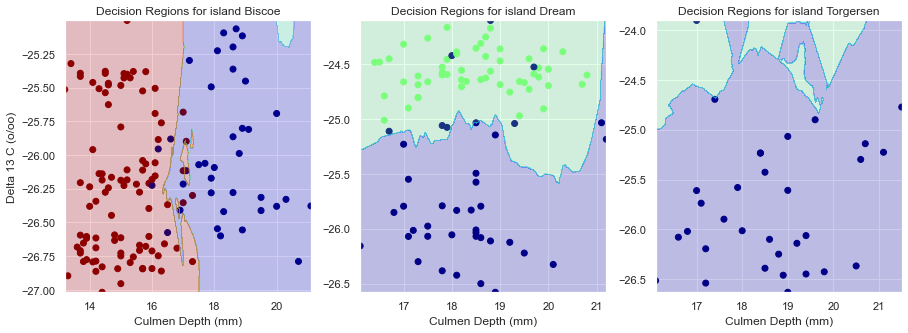

In [62]:
best_set = ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island']
X=X_train_3[best_set[:2]]
y=y_train

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))   
plot_regions(KNN,X,y,0)
plot_regions(KNN,X,y,1)
plot_regions(KNN,X,y,2)

Compare to the scatterplots generated by the penguin data set with same feature set in real situation:

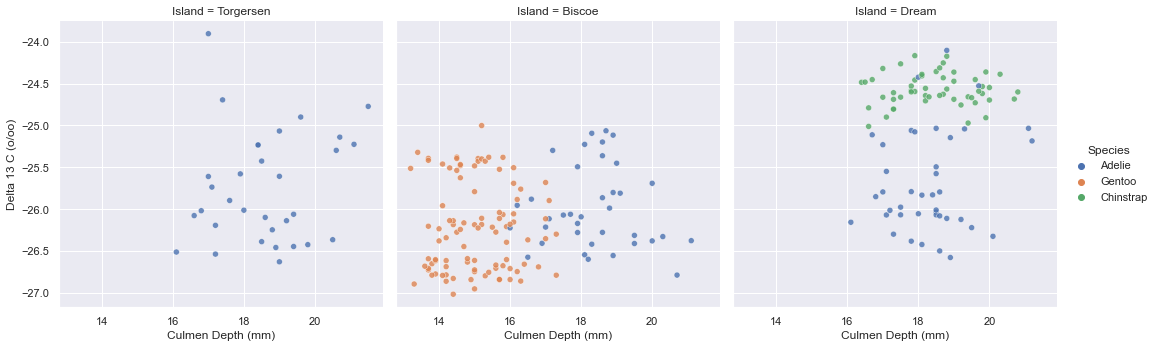

In [63]:
# Spcecies vs Delta 13 C and Culmen Depth vs Island
fgrid = sns.relplot(data = penguin, y = "Delta 13 C (o/oo)", 
                    x='Culmen Depth (mm)', hue = "Species", 
                    alpha = 0.8, col = "Island")

- Blue: Adelie Penguin 

- Green: Chinstrap Penguin

- Red: Gentoo Penguin

**Performance:** Achieved an accuracy score of  **0.9385** from KNN classifier with features ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island'].

Random Forest outperforms KNN, and is the best model at this point.

**Discussion:**
KNN classifier generates a less smooth decision boundaries in the decision region plots. The model incorrectly classifies some of the points in the dataset because the boundaries are blurrier between Gentoo and Adelie on the Biscoe island, and between Chinstrap and Adelie on the Dream island. The outliers in Adelie penguins with respect to culmen depth were classfied as Gentoo penguins. The outliers in Adelie penguins with respect to Delta 13 C were classified as Chinstrap penguins by the model.

### (III) Support Vector Machine

In [64]:
from sklearn import svm

best_score = 0
gamma_range = [x * 0.01 for x in range (1, 10)]+[x * 0.1 for x in range (1, 10)]+ list(range(1, 11))
for train_option in trainOptions:
    for d in gamma_range:
        SVM = svm.SVC(gamma = d)
        cv_score = cross_val_score(SVM, train_option, 
                                   y_train, cv=10).mean()

        if cv_score > best_score:
            best_gamma = d
            best_score = cv_score
    print("Best gamma ", best_gamma, 
          " for ", [i for i in train_option.columns],
         "with best cv score as ", best_score, "\n")
    best_score = 0

Best gamma  0.7000000000000001  for  ['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island'] with best cv score as  0.9115384615384616 

Best gamma  0.9  for  ['Delta 13 C (o/oo)', 'Body Mass (g)', 'Island'] with best cv score as  0.811076923076923 

Best gamma  2  for  ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island'] with best cv score as  0.9344615384615385 



In [65]:
SVM = svm.SVC(gamma = 2)
SVM.fit(X_train_3, y_train)
y_pred = SVM.predict(X_test_3)

In [66]:
print(classification_report(y_test,y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.88      1.00      0.93        14
           2       0.95      1.00      0.98        21

    accuracy                           0.95        65
   macro avg       0.94      0.97      0.95        65
weighted avg       0.96      0.95      0.95        65



array([[27,  2,  1],
       [ 0, 14,  0],
       [ 0,  0, 21]], dtype=int64)

In [67]:
print ("Accuracy : ", accuracy_score(y_test, y_pred))
print("Test score: ",SVM.score(X_test_3, y_test))
print("Training score: ", SVM.score(X_train_3, y_train))

Accuracy :  0.9538461538461539
Test score:  0.9538461538461539
Training score:  0.9536679536679536


C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


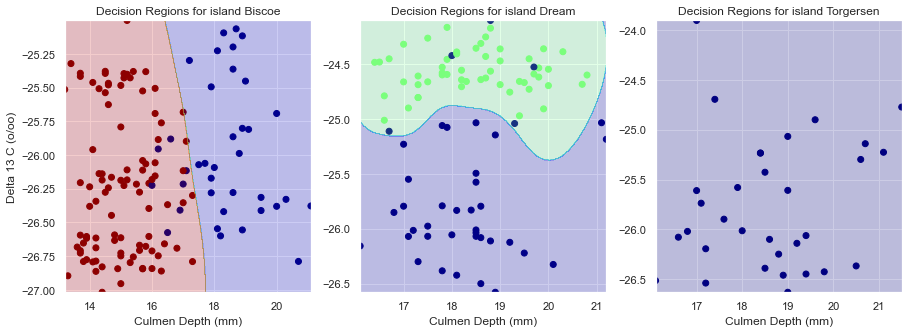

In [68]:
best_set = ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island']
X=X_train_3[best_set[:2]]
y=y_train

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))   
plot_regions(SVM,X,y,0)
plot_regions(SVM,X,y,1)
plot_regions(SVM,X,y,2)

- Blue: Adelie Penguin 

- Green: Chinstrap Penguin

- Red: Gentoo Penguin

**Performance:** Achieved an accuracy score of **0.9538** from SVM classifier with features ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island'] 

Random Forest still outperforms, and is the best model at this point.However, by focusing on the decision boundaries plots, SVM produces a better prediction on the decision regions than Random Forest.

**Discussion:**
SVM classifier generates a smooth decision boundaries in the decision region plots. The model incorrectly classifies some of the points in the dataset for the same reason as in the KNN model. The outliers in Adelie penguins with respect to culmen depth were classfied as Gentoo penguins. The outliers in Adelie penguins with respect to Delta 13 C were classified as Chinstrap penguins by the model. However, the model correctly classified all Adelie penguins on the Torgensen island.

### (IV) Logistic Regression

In [69]:
trainOptions= [['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island'],
        ['Delta 13 C (o/oo)', 'Body Mass (g)', 'Island'],
         ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island']]

for combo in trainOptions:
    x=check_column_score(combo)
    print("Best CV score is ", x, 
          " for ", [i for i in train_option], "\n")

training with columns['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island']
Best CV score is  0.9573846153846155  for  ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island'] 

training with columns['Delta 13 C (o/oo)', 'Body Mass (g)', 'Island']
Best CV score is  0.9187692307692309  for  ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island'] 

training with columns['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island']
Best CV score is  0.9149230769230771  for  ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Island'] 



In [70]:
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_1, y_train)
y_pred = LR.predict(X_test_1)
y_pred

array([2, 0, 1, 2, 0, 0, 2, 1, 2, 0, 0, 2, 1, 2, 1, 2, 2, 0, 0, 2, 1, 2,
       1, 1, 0, 0, 2, 0, 1, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 1, 1,
       0, 2, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 1, 0, 2, 2, 0, 0, 1, 1, 0])

In [71]:
print(classification_report(y_test,y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.88      1.00      0.93        14
           2       1.00      1.00      1.00        21

    accuracy                           0.97        65
   macro avg       0.96      0.98      0.97        65
weighted avg       0.97      0.97      0.97        65



array([[28,  2,  0],
       [ 0, 14,  0],
       [ 0,  0, 21]], dtype=int64)

In [72]:
print ("Accuracy : ", accuracy_score(y_test, y_pred))
print("Test score: ",LR.score(X_test_1, y_test))
print("Training score: ", LR.score(X_train_1, y_train))

Accuracy :  0.9692307692307692
Test score:  0.9692307692307692
Training score:  0.9498069498069498


C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


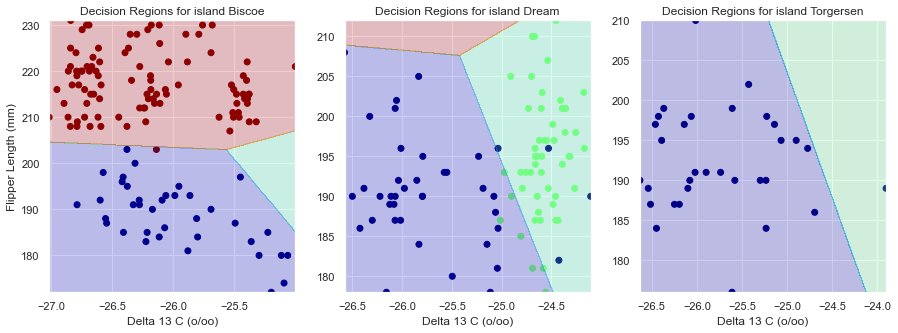

In [73]:
best_set = ['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island']
X=X_train_1[best_set[:2]]
y=y_train

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))   
plot_regions(LR,X,y,0)
plot_regions(LR,X,y,1)
plot_regions(LR,X,y,2)

- Blue: Adelie Penguin 

- Green: Chinstrap Penguin

- Red: Gentoo Penguin

**Performance:** Achieved an accuracy score of  **0.9692** from Logistic Regression classifier with features ['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island'] 

Random Forest outperforms all the models we implemented!

**Discussion:**
Logistic Regression classifier incorrectly classifies some of the points in the dataset for the same reason as in the Random Forest model. The outliers in Adelie penguins with respect to Delta 13 C were classfied as Gentoo penguins. The outliers in Gentoo penguins with respect to Flipper length were classified as Adelie penguins by the model. 

# Discussion

Our candidate four models give relatively high accuracy over 0.93 in predicting the species:
- In the Random Forest model, we have 0.9846 as our testing score (accuracy between testing data and predicting data) and 0.9807 as our training score.
- In the K Nearest Neighbor model, we have 0.9385 as our testing score (accuracy between testing data and predicting data) and 0.9266 as our training score.
- In the Support Vector Machine model, we have 0.9538 as our testing score (accuracy between testing data and predicting data) and 0.9537 as our training score.
- In the Logistic Regression model, we have 0.9692 as our testing score (accuracy between testing data and predicting data) and 0.9498 as our training score.

Combined with the accuracy scores and the decision regions plots for each model, we would consider the Random Forest model as the best recommendation with the feature subset `['Delta 13 C (o/oo)', 'Flipper Length (mm)', 'Island']` because the model produces the predicted data with highest accuracy and its decision region has relatively small mistake.

In our view, our concern about our models is their potential problem of overfitting, and this limitation comes from our training data, because our training data only has 259 observations, and the models we made are based on this small size data set, so the accuracy they show will be very high.If we apply a larger data set containing thousands even millions of observation, the accuracy of our model might not be as high as they are now.

To improve our model, firstly, using a larger data set containing much more obervations might help our model improve the accuracy in predicting data fitting with the real specie data and compatibility with a larger data set or a data set with different qualitative and quantitative variables.Moreover, we think that tunning the complexity parameters of the model with a larger potential range might also help us improve our model. When we cross-validation to choose the `max_depth` parameter, we noticed that the random forest model would run longer time than the other candidate models, so giving more time to try a larger range of model parameters would be a tip to improve the model as well.